In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors, ticker
import netCDF4 as nc
import sys
sys.path.insert(1, '..')
from functions import *
from thermofunctions import qsatur, rlv, rd, rv, cp
import seaborn as sns

In [3]:
lp = '../../bomex200_e12'
sp = lp+'/figs'
it = 63
izmin = 0
izmax = 80
klp = 4
ix = 372
iz = 37
iz0 = 15
iz1 = 37
fq = 1000 # kg/kg => g/kg
fwql = 7*300 # kg/kg m/s => K m/s
generate_slice = False

In [4]:
if generate_slice:
    ds = nc.Dataset(lp+'/fielddump.001.nc')
    ds1= nc.Dataset(lp+'/profiles.001.nc')
    
    time  = np.ma.getdata(ds.variables['time'][:]) / 3600
    zf    = np.ma.getdata(ds.variables['zt'][:]) # Cell centres (f in mhh)
    zh    = np.ma.getdata(ds.variables['zm'][:]) # Cell edges (h in mhh)
    xf    = np.ma.getdata(ds.variables['xt'][:]) # Cell centres (f in mhh)
    
    time1d = np.ma.getdata(ds1.variables['time'][:])
    rhobf = np.ma.getdata(ds1.variables['rhobf'][:])
    rhobh = np.ma.getdata(ds1.variables['rhobh'][:])
    
    dx = np.diff(xf)[0]
    dy = np.diff(xf)[0] # Assumes uniform horizontal spacing
    
    # Vertical differences
    dzf = np.zeros(zh.shape)
    dzf[:-1] = zh[1:] - zh[:-1] # First value is difference top 1st cell and surface
    dzf[-1] = dzf[-2]
    
    dzh = np.zeros(zf.shape)
    dzh[1:] = zf[1:] - zf[:-1] # First value is difference mid 1st cell and mid 1st cell below ground
    dzh[0] = 2*zf[1]
    
    delta = (dx*dy*np.diff(zh))**(1./3)
    
    dzflim = dzf[izmin:izmax]
    dzhlim = dzh[izmin:izmax]
    
    zflim = zf[izmin:izmax]
    zhlim = zh[izmin:izmax]
    
    # Mask for low-[ass filtering
    circ_mask = np.zeros((xf.size,xf.size))
    rad = getRad(circ_mask)
    circ_mask[rad<=klp] = 1
    
    it1d = np.argmin(np.abs(time1d/3600 - time[it]))
    
    # 1D fields
    rhobfi = rhobf[it1d,izmin:izmax]
    rhobhi = rhobh[it1d,izmin:izmax]
    
    # 3D fields
    qt  = np.ma.getdata(ds.variables['qt'][it,izmin:izmax,:,:])
    u = np.ma.getdata(ds.variables['u'][it,izmin:izmax,:,:])
    v = np.ma.getdata(ds.variables['v'][it,izmin:izmax,:,:])
    wh = np.ma.getdata(ds.variables['w'][it,izmin:izmax+1,:,:])
    thl =  np.ma.getdata(ds.variables['thl'][it,izmin:izmax,:,:])
    ql = np.ma.getdata(ds.variables['ql'][it,izmin:izmax,:,:])
    if 'p' in ds.variables.keys():
        p = np.ma.getdata(ds.variables['p'][it,izmin:izmax,:,:])
    
    # w  h-> f-levels
    wf = (wh[1:,:,:] + wh[:-1,:,:])*0.5
    wh = wh[:-1,:,:]
    
    # Tempereature and saturation specific humidity
    presh  = np.ma.getdata(ds1.variables['presh'][it1d,izmin:izmax])
    presf  = (presh[1:]+presh[:-1])*0.5
    exnf   = (presf/1e5)**(Rd/cp)
    
    T = exnf[:,np.newaxis,np.newaxis]*thl[:-1,:,:] + rlv/cp*ql[:-1,:,:]
    qs = qsatur(T,presf[:,np.newaxis,np.newaxis])
    
    # Scale decompose
    twp = np.trapz(rhobfi[:,np.newaxis,np.newaxis]*qt[:,:,:],zflim,axis=0)
    twpp=twp-np.mean(twp)
    twppf = lowPass(twpp,circ_mask)
    
    wff = lowPass(wf, circ_mask)
    wfp = wf - wff
    
    up = u - np.mean(u,axis=(1,2))[:,np.newaxis,np.newaxis]
    upf = lowPass(up, circ_mask)
    
    qt_av = np.mean(qt,axis=(1,2))
    qtp = qt - qt_av[:,np.newaxis,np.newaxis]
    qtpf = lowPass(qtp, circ_mask)
    
    thl_av = np.mean(thl,axis=(1,2))
    
    thlv = thl + 0.608*thl_av[:,np.newaxis,np.newaxis]*qt
    thlv_av = np.mean(thlv,axis=(1,2))
    thlvp = thlv - thlv_av[:,np.newaxis,np.newaxis]
    
    ql_av = np.mean(ql,axis=(1,2))
    qlp = ql - ql_av[:,np.newaxis,np.newaxis]
    
    wql = wf*ql
    wqlf = lowPass(wql,circ_mask)
    wqlp = wf*qlp
    wqlpf = lowPass(wqlp,circ_mask)
    wthlvp = wf*thlvp
    wthlvpf = lowPass(wthlvp,circ_mask)
    
    ddxhuh = (np.roll(u,-1,axis=2) - u)/dx + (np.roll(v,-1,axis=1) - v)/dy
    
    div_wql = ddzwx_2nd(wh, qlp, dzflim, dzhlim, rhobf=rhobfi)
    div_wql_av = np.mean(div_wql,axis=(1,2))
    div_wqlf = lowPass(div_wql, circ_mask)

    # Store necesasry fields to make figures
    qtplt = qt[:,ix,:]
    qlplt = ql[:,ix,:]
    qtpfplt = qtpf[:,ix,:]
    upfplt = upf[:,ix,:]
    wffplt = wff[:,ix,:]
    qsplt = qs[:,ix,:]
    wqlfplt = wqlf[:,ix,:]
    wthlvpplt = wthlvp[iz,ix,:]-np.mean(wthlvp[iz,:,:])
    wthlvpfplt = wthlvpf[iz,ix,:]-np.mean(wthlvp[iz,:,:])
    wqlpplt = 7*thl_av[iz]*(wqlp[iz,ix,:]-np.mean(wqlp[iz,:,:]))
    wqlpfplt = 7*thl_av[iz]*(wqlpf[iz,ix,:]-np.mean(wqlp[iz,:,:]))
    
    np.save(lp+'/fig_data/qtplf.npy',qtplt)
    np.save(lp+'/fig_data/qlplt.npy',qlplt)
    np.save(lp+'/fig_data/qtpfplt.npy',qtpfplt)
    np.save(lp+'/fig_data/upfplt.npy',upfplt)
    np.save(lp+'/fig_data/wffplt.npy',wffplt)
    np.save(lp+'/fig_data/zflim.npy',zflim)
    np.save(lp+'/fig_data/xf.npy',xf)
    np.save(lp+'/fig_data/qsplt.npy',qsplt)
    np.save(lp+'/fig_data/wqlfplt.npy',wqlfplt)
    np.save(lp+'/fig_data/wthlvpplt.npy',wthlvpplt)
    np.save(lp+'/fig_data/wthlvpfplt.npy',wthlvpfplt)
    np.save(lp+'/fig_data/wqlpplt.npy',wqlpplt)
    np.save(lp+'/fig_data/wqlpfplt.npy',wqlpfplt)
    

if not generate_slice:
    qtplt = np.load(lp+'/fig_data/qtplf.npy')
    qlplt = np.load(lp+'/fig_data/qlplt.npy')
    qtpfplt = np.load(lp+'/fig_data/qtpfplt.npy')
    upfplt = np.load(lp+'/fig_data/upfplt.npy')
    wffplt = np.load(lp+'/fig_data/wffplt.npy')
    zflim = np.load(lp+'/fig_data/zflim.npy')
    xf = np.load(lp+'/fig_data/xf.npy')
    qsplt = np.load(lp+'/fig_data/qsplt.npy')
    wqlfplt = np.load(lp+'/fig_data/wqlfplt.npy')
    wthlvpplt = np.load(lp+'/fig_data/wthlvpplt.npy')
    wthlvpfplt = np.load(lp+'/fig_data/wthlvpfplt.npy')
    wqlpplt = np.load(lp+'/fig_data/wqlpplt.npy')
    wqlpfplt = np.load(lp+'/fig_data/wqlpfplt.npy')

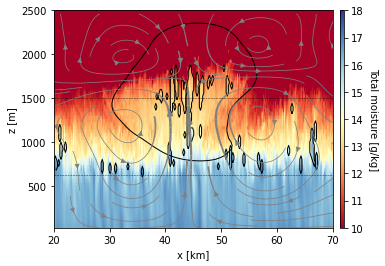

In [5]:
#%% First inset
extent=[20,70,20,2500]
fig = plt.figure(figsize=(5,4)); axs = plt.gca()
sc0 = axs.imshow(np.flipud(qtplt[:62,100:350])*fq,
                        extent=extent,
                        aspect='auto',cmap='RdYlBu',
                        vmin=0.01*fq,vmax=0.018*fq)
pos = axs.get_position()
cbax0=fig.add_axes([.92, pos.ymin, 0.01, pos.height])
cb0 = fig.colorbar(sc0, cax=cbax0)
cb0.ax.set_ylabel(r"Total moisture [g/kg]", rotation=270, labelpad=15)

axs.contour(qlplt[:62,100:350],levels=[1e-7],extent=extent,origin='lower',linewidths=1,colors='black')

axs.contour(qtpfplt[:62,100:350],levels=[0.0004],extent=extent,origin='lower',linewidths=1,colors='black')# ,linestyles='dashed')
xfstr = np.linspace(20,102300,512)/1000
[X,Y] = np.meshgrid(xfstr,np.arange(20,2500,40))
speed = np.sqrt((upfplt[:62,:]/1000)**2+wffplt[:62,:]**2)
lws = np.maximum(.75,3.*speed/np.max(speed))
st = axs.streamplot(X,Y,upfplt[:62,:]/1000,wffplt[:62,:],linewidth=lws, density=1,color='grey')
axs.axhline(zflim[iz0],linestyle='--',color='k',alpha=0.8,linewidth=0.5)
axs.axhline(zflim[iz1],linestyle='--',color='k',alpha=0.8,linewidth=0.5)

axs.set_xlabel('x [km]')
axs.set_ylabel('z [m]')
axs.set_xlim(extent[0:2])
plt.savefig(sp+'/concept_1.svg',bbox_inches='tight',dpi=300)
plt.show()

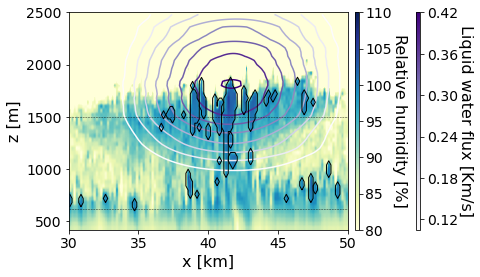

In [5]:
#%% Second inset
extent=[30,50,zflim[10],2500]
fig = plt.figure(figsize=(5,4)); axs = plt.gca()
sc0 = axs.imshow(np.flipud(qtplt[10:62,150:275]/qsplt[10:62,150:275]*100),
                        extent=extent,
                        aspect='auto',cmap='YlGnBu',
                        vmin=80,vmax=110)
pos = axs.get_position()
cbax0=fig.add_axes([.92, pos.ymin, 0.01, pos.height])
cb0 = fig.colorbar(sc0, cax=cbax0)
cb0.ax.set_ylabel(r"Relative humidity [%]", rotation=270, labelpad=15,fontsize=16)
cb0.ax.tick_params(labelsize=14)

sc1 = axs.contour(wqlfplt[10:62,150:275]*fwql,extent=extent,origin='lower',linewidths=1.5,cmap='Purples',levels=np.linspace(0.00005*fwql,0.0002*fwql,8))
cbax1=fig.add_axes([1.09, pos.ymin, 0.01, pos.height])
norm = colors.Normalize(vmin=sc1.cvalues.min(), vmax=sc1.cvalues.max())
sm = plt.cm.ScalarMappable(norm=norm, cmap=sc1.cmap)
sm.set_array([])
cb1 = fig.colorbar(sm, cax=cbax1)
cb1.ax.set_ylabel(r"Liquid water flux [Km/s]", rotation=270, labelpad=15, fontsize=16)
cb1.ax.tick_params(labelsize=14)
cb1.locator = ticker.MaxNLocator(nbins=6)
cb1.update_ticks()
axs.contour(qlplt[10:62,150:275],levels=[1e-7],extent=extent,origin='lower',linewidths=1,colors='black')

axs.axhline(zflim[iz0],linestyle='--',color='k',alpha=0.8,linewidth=0.5)
axs.axhline(zflim[iz1],linestyle='--',color='k',alpha=0.8,linewidth=0.5)

axs.set_xlabel('x [km]',fontsize=16)
axs.set_ylabel('z [m]',fontsize=16)
axs.tick_params(axis='both', labelsize=14)

axs.set_xlim(extent[0:2])
plt.savefig(sp+'/concept_2.svg',bbox_inches='tight',dpi=300)
plt.show()

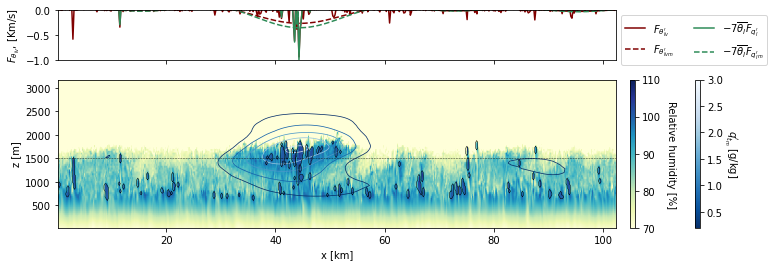

In [6]:
#%% Flux origins
extent=[xf[0]/1000,xf[-1]/1000,zflim[0],zflim[-1]-1]
fig,axs = plt.subplots(figsize=(10,4),nrows=2,sharex=True,gridspec_kw={'height_ratios':[1,3]})
sc0 = axs[1].imshow(np.flipud(qtplt[:-1,:]/qsplt*100),
                        extent=extent,
                        aspect='auto',cmap='YlGnBu',
                        vmin=70,vmax=110)
pos = axs[1].get_position()
cbax0=fig.add_axes([.92, pos.ymin, 0.007, pos.height])
cb0 = fig.colorbar(sc0, cax=cbax0)
cb0.ax.set_ylabel(r"Relative humidity [%]", rotation=270, labelpad=15)

sc1 = axs[1].contour(qtpfplt[:-1,:]*1000,extent=extent,origin='lower',linewidths=0.75,cmap='Blues_r',levels=np.linspace(0.2,3,6))
cbax1=fig.add_axes([1.01, pos.ymin, 0.007, pos.height])
norm = colors.Normalize(vmin=sc1.cvalues.min(), vmax=sc1.cvalues.max())
sm = plt.cm.ScalarMappable(norm=norm, cmap=sc1.cmap)
sm.set_array([])
cb1 = fig.colorbar(sm, cax=cbax1)
cb1.ax.set_ylabel(r"$q_{t_m}'$ [g/kg]", rotation=270, labelpad=15)
cb1.locator = ticker.MaxNLocator(nbins=6)
cb1.update_ticks()
axs[1].contour(qlplt[:-1,:],levels=[1e-7],extent=extent,origin='lower',linewidths=0.5,colors='black')
axs[1].axhline(zflim[iz],linestyle='--',color='k',alpha=0.8,linewidth=0.5)
axs[1].set_xlabel('x [km]')
axs[1].set_ylabel('z [m]')

axs[0].plot(xf/1000,wthlvpplt,c='maroon',label=r"$F_{\theta_{lv}'}$")
axs[0].plot(xf/1000,wthlvpfplt,c='maroon',linestyle='dashed',label=r"$F_{{\theta_{lv}'}_m}$")
axs[0].plot(xf/1000,-wqlpplt,c='seagreen',label=r"$-7\overline{\theta_l}F_{q_l'}$")
axs[0].plot(xf/1000,-wqlpfplt,c='seagreen',linestyle='dashed',label=r"$-7\overline{\theta_l}F_{{q_l'}_m}$")
axs[0].set_ylim((-1,0))
axs[0].set_ylabel(r"$F_{\theta_{lv}}$, [Km/s]")
axs[0].legend(bbox_to_anchor=(1,1),loc='upper left',ncol=2)

plt.savefig(sp+'/structure.pdf',bbox_inches='tight',dpi=300)
plt.show()

In [73]:
# Attempt to calculate the contribution towards wthlvpmf from the sub-kilometre scales, in baseline and 5th order adv

calc_fluxes = False

if calc_fluxes:
    tmin = 16
    tmax = 18
    lsmall = 2 # km

    lps = ['../../bomex100_e12',
           '../../bomex100a5_from100_12hr',
           '../../bomex200_from100_12hr']

    for l in range(len(lps)):
        lp = lps[l]

        ds = nc.Dataset(lp+'/fielddump.001.nc')
        time = np.ma.getdata(ds['time'][:])/3600
        xf = np.ma.getdata(ds.variables['xt'][:])

        lk = xf.max() / np.arange(1, len(xf) // 2 + 1) / 1000
        ksm = np.argmin(np.abs(lk-lsmall))

        itmin = np.argmin(np.abs(time - tmin))
        itmax = np.argmin(np.abs(time - tmax))
        plttime = np.arange(itmin,itmax+1)

        # print(time[itmin:itmax])

        circ_mask = np.zeros((xf.size,xf.size))
        rad = getRad(circ_mask)
        circ_mask[rad<=klp] = 1

        wthlvpf_anom_moist = np.zeros((plttime.size, zflim.size))
        wthlvpf_anom_dry = np.zeros((plttime.size, zflim.size))
        wthlvpf_sm_anom_moist = np.zeros((plttime.size, zflim.size))
        wthlvpf_sm_anom_dry = np.zeros((plttime.size, zflim.size))

        for i in range(len(plttime)):
            it = plttime[i]
            wh = np.ma.getdata(ds.variables['w'][it,izmin:izmax+1,:,:])
            thl =  np.ma.getdata(ds.variables['thl'][it,izmin:izmax,:,:])
            qt  = np.ma.getdata(ds.variables['qt'][it,izmin:izmax,:,:])

            # w  h-> f-levels
            wf = (wh[1:,:,:] + wh[:-1,:,:])*0.5
            wh = wh[:-1,:,:]

            thl_av = np.mean(thl,axis=(1,2))

            thlv = thl + 0.608*thl_av[:,np.newaxis,np.newaxis]*qt
            thlv_av = np.mean(thlv,axis=(1,2))
            thlvp = thlv - thlv_av[:,np.newaxis,np.newaxis]

            # moist/dry
            twp = np.trapz(qt,zflim,axis=0)
            twpp=twp-np.mean(twp)
            twppf = lowPass(twpp,circ_mask)
            mask_moist = np.zeros(twppf.shape)
            mask_moist[twppf > 0] = 1
            mask_dry = 1 - mask_moist

            # Mesoscale flux
            wthlvp = wf*thlvp
            wthlvp_av = np.mean(wthlvp,axis=(1,2))

            wthlvpf = lowPass(wthlvp,circ_mask)

            wthlvpf_moist = mean_mask(wthlvpf,mask_moist)
            wthlvpf_dry = mean_mask(wthlvpf,mask_dry)

            wthlvpf_anom_moist[i,:] = wthlvpf_moist - wthlvp_av
            wthlvpf_anom_dry[i,:] = wthlvpf_dry - wthlvp_av

            # Flux from sub-km scales
            circ_mask_sm = np.zeros((xf.size,xf.size))
            rad = getRad(circ_mask_sm)
            circ_mask_sm[rad>=ksm] = 1

            wsm = lowPass(wf, circ_mask_sm) # But is really high pass, since the function just multiplies by the mask
            thlvpsm = lowPass(thlvp, circ_mask_sm)

            wthlvp_sm = wsm*thlvpsm
            wthlvp_sm_av = np.mean(wthlvp_sm,axis=(1,2))

            wthlvpf_sm = lowPass(wthlvp_sm, circ_mask)

            wthlvpf_sm_moist = mean_mask(wthlvpf_sm,mask_moist)
            wthlvpf_sm_dry = mean_mask(wthlvpf_sm,mask_dry)

            wthlvpf_sm_anom_moist[i,:] = wthlvpf_sm_moist - wthlvp_sm_av
            wthlvpf_sm_anom_dry[i,:] = wthlvpf_sm_dry - wthlvp_sm_av

        np.save(lp+'/wthlvpf_anom_moist.npy',wthlvpf_anom_moist)
        np.save(lp+'/wthlvpf_anom_dry.npy',wthlvpf_anom_dry)
        np.save(lp+'/wthlvpf_sm_anom_moist.npy',wthlvpf_sm_anom_moist)
        np.save(lp+'/wthlvpf_sm_anom_dry.npy',wthlvpf_sm_anom_dry)

/home/janssens/.conda/envs/ppaggenv/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app
/home/janssens/.conda/envs/ppaggenv/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  app.launch_new_instance()
/home/janssen

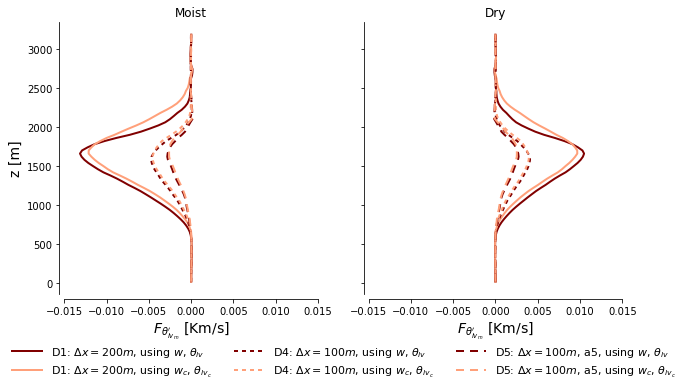

In [92]:
lps = ['../../bomex200_from100_12hr',
       '../../bomex100_e12',
       '../../bomex100a5_from100_12hr',
       ]

lab_var = [r"using $w$, $\theta_{lv}$",
           r"using $w_c$, $\theta_{lv_c}$",
          ]

lab_sim = [r'D1: $\Delta x = 200m$',
#            r'D3: $\Delta x = 200m$, fiso',
           r'D4: $\Delta x = 100m$',
           r'D5: $\Delta x = 100m$, a5',
#            r'D6: $\Delta x = 100m$, nocorr',
          ]

lines = ['-',
#          (0, (3, 2, 1, 2, 1, 2)),
         (0,(2,2)),
         (0,(4,3)),
#          (0,(1,3))
        ]

col = [
       'maroon',
       'lightsalmon',
      ]

alpha = 1
lw = 2

fig,axs = plt.subplots(nrows=1,ncols=2,sharey=True,figsize=(10,5))
for i in range(len(lps)):
    lp = lps[i]
    
    wthlvpf_anom_moist = np.load(lp+'/wthlvpf_anom_moist.npy')
    wthlvpf_anom_dry = np.load(lp+'/wthlvpf_anom_dry.npy')
    wthlvpf_sm_anom_moist = np.load(lp+'/wthlvpf_sm_anom_moist.npy')
    wthlvpf_sm_anom_dry = np.load(lp+'/wthlvpf_sm_anom_dry.npy')

    wthlvpf_anom_moist_mn = np.mean(wthlvpf_anom_moist,axis=0)
    wthlvpf_anom_dry_mn = np.mean(wthlvpf_anom_dry,axis=0)
    wthlvpf_sm_anom_moist_mn = np.mean(wthlvpf_sm_anom_moist,axis=0)
    wthlvpf_sm_anom_dry_mn = np.mean(wthlvpf_sm_anom_dry,axis=0)

    axs[0].plot(wthlvpf_anom_moist_mn,zflim,alpha=alpha,lw=lw,c=col[0],linestyle=lines[i])
    axs[0].plot(wthlvpf_sm_anom_moist_mn,zflim,alpha=alpha,lw=lw,c=col[1],linestyle=lines[i])

    axs[1].plot(wthlvpf_anom_dry_mn,zflim,alpha=alpha,lw=lw,c=col[0],linestyle=lines[i],label=lab_sim[i]+', '+lab_var[0])
    axs[1].plot(wthlvpf_sm_anom_dry_mn,zflim,alpha=alpha,lw=lw,c=col[1],linestyle=lines[i],label=lab_sim[i]+', '+lab_var[1])
    
axs[0].set_title('Moist')
axs[0].set_ylabel('z [m]',fontsize=14)
axs[0].set_xlabel(r"$F_{\theta_{lv_m}'}$ [Km/s]",fontsize=14)
axs[0].set_xlim((-0.015,0.015))

axs[1].set_title('Dry')
axs[1].set_xlabel(r"$F_{\theta_{lv_m}'}$ [Km/s]",fontsize=14)
axs[1].set_xlim((-0.015,0.015))
axs[1].legend(bbox_to_anchor=(1.25,-0.15),ncol=len(lps),frameon=False,handlelength=2.75,fontsize=11)
sns.despine(offset=5)
plt.savefig(lp+'/../bomex_comparisons/flux_anomaly_convective.pdf',bbox_inches='tight')
